In [1]:
import pandas as pd
import scipy as sc
import numpy as np
import os


import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import colorConverter
import seaborn as sns

%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic
%matplotlib inline

/home/dslochower/data/applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/dslochower/data/applications/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Project-level imports.

In [3]:
from constants import guest_types
from constants import colors
from bootstrap import bootstrap
from bootstrap import thermodynamic_bootstrap
import plotting

# Load in results

## Experimental data from Rekharsky et al.

In [26]:
from constants import experimental_deltaH

In [27]:
experimental_list = experimental_deltaH.split("\n")
experimental = pd.DataFrame([i.split("\t") for i in experimental_list],
            columns=["System", "Delta H", "SEM"])
experimental["Delta H"] = pd.to_numeric(experimental["Delta H"])
experimental["SEM"] = pd.to_numeric(experimental["SEM"])

In [28]:
experimental.head()

,System,Delta H,SEM
0,a-bam,-2.17,0.05
1,a-nmb,-2.57,0.06
2,a-mba,-2.68,0.07
3,a-pam,-3.28,0.02
4,a-ham,-4.19,0.02


## Load in the BGBG-TIP3P and BGBG-TIP3P data

In [29]:
from constants import systems

In [32]:
bgbg_tip3p = pd.DataFrame()

for system in systems:

    # BGBG-TIP3P (GAFF v1.7)

    with open(f"results/{system}-bgbg_tip3p-enthalpy-full.json", "r") as f:
        json_data = f.read()
    loaded = json.loads(json_data)
    
    
    bgbg_tip3p = bgbg_tip3p.append(pd.DataFrame({'System': system,
                                 'total' : loaded["a00"]["total"][0] - loaded["r00"]["total"][0],
                                 'bond': loaded["a00"]["bond"][0] - loaded["r00"]["bond"][0],
                                 'ele': loaded["a00"]["ele"][0] - loaded["r00"]["ele"][0],
                                 'vdw': loaded["a00"]["vdw"][0] - loaded["r00"]["vdw"][0],
                                 
                                 'total_sem' : np.sqrt(loaded["a00"]["total"][1]**2 + loaded["r00"]["total"][1]**2),
                                 'bond_sem': np.sqrt(loaded["a00"]["bond"][1]**2 + loaded["r00"]["bond"][1]**2),
                                 'ele_sem': np.sqrt(loaded["a00"]["ele"][1]**2 + loaded["r00"]["ele"][1]**2),
                                 'vdw_sem': np.sqrt(loaded["a00"]["vdw"][1]**2 + loaded["r00"]["vdw"][1]**2),
                                 
                                 'Type': guest_types[system[0:-2]]
                                }, index=[0]), ignore_index=True)

In [48]:
bg2bg2_tip3p = pd.DataFrame()

for system in systems:

    # BG2BG2-TIP3P (GAFF v2.1)

    with open(f"results/{system}-bg2bg2_tip3p-enthalpy-full.json", "r") as f:
        json_data = f.read()
    loaded = json.loads(json_data)
    
    
    bg2bg2_tip3p = bg2bg2_tip3p.append(pd.DataFrame({'System': system,
                                 'total' : loaded["a00"]["total"][0] - loaded["r00"]["total"][0],
                                 'bond': loaded["a00"]["bond"][0] - loaded["r00"]["bond"][0],
                                 'ele': loaded["a00"]["ele"][0] - loaded["r00"]["ele"][0],
                                 'vdw': loaded["a00"]["vdw"][0] - loaded["r00"]["vdw"][0],
                                 
                                 'total_sem' : np.sqrt(loaded["a00"]["total"][1]**2 + loaded["r00"]["total"][1]**2),
                                 'bond_sem': np.sqrt(loaded["a00"]["bond"][1]**2 + loaded["r00"]["bond"][1]**2),
                                 'ele_sem': np.sqrt(loaded["a00"]["ele"][1]**2 + loaded["r00"]["ele"][1]**2),
                                 'vdw_sem': np.sqrt(loaded["a00"]["vdw"][1]**2 + loaded["r00"]["vdw"][1]**2),
                                 
                                 'Type': guest_types[system[0:-2]]
                                }, index=[0]), ignore_index=True)

In [49]:
bg2bg2_tip3p.head()

,System,Type,bond,bond_sem,ele,ele_sem,total,total_sem,vdw,vdw_sem
0,a-bam-p,aliphatic_ammoniums,-0.567215,0.014850,1.737371,0.438272,-2.874973,0.304159,-3.654947,0.183604
1,a-bam-s,aliphatic_ammoniums,-0.342138,0.011158,-0.704047,0.481603,-3.051844,0.385293,-2.539906,0.160997
2,a-but-p,aliphatic_carboxylates,-0.440130,0.012469,-2.798134,0.551853,-4.580844,0.386328,-3.017552,0.192461
3,a-but-s,aliphatic_carboxylates,-0.175048,0.012277,-5.492363,0.601743,-4.931365,0.440484,-1.151212,0.184855
4,a-cbu-p,cyclic_alcohols,-0.203307,0.013997,-2.230962,0.400777,-4.469728,0.286022,-3.136942,0.142404


## Load in SMIRNOFF99Frosst data

In [10]:
from paprika.restraints_json import json_numpy_obj_hook

In [14]:
import json

In [34]:
smirnoff = pd.DataFrame()

for system in systems:
    with open(f"results/{system}-smirnoff-enthalpy-full.json", "r") as f:
        json_data = f.read()
    loaded = json.loads(json_data)
    
    
    smirnoff = smirnoff.append(pd.DataFrame({'System': system,
                                 'total' : loaded["a000"]["total"][0] - loaded["r014"]["total"][0],
                                 'bond': loaded["a000"]["bond"][0] - loaded["r014"]["bond"][0],
                                 'ele': loaded["a000"]["ele"][0] - loaded["r014"]["ele"][0],
                                 'vdw': loaded["a000"]["vdw"][0] - loaded["r014"]["vdw"][0],
                                 
                                 'total_sem' : np.sqrt(loaded["a000"]["total"][1]**2 + loaded["r014"]["total"][1]**2),
                                 'bond_sem': np.sqrt(loaded["a000"]["bond"][1]**2 + loaded["r014"]["bond"][1]**2),
                                 'ele_sem': np.sqrt(loaded["a000"]["ele"][1]**2 + loaded["r014"]["ele"][1]**2),
                                 'vdw_sem': np.sqrt(loaded["a000"]["vdw"][1]**2 + loaded["r014"]["vdw"][1]**2),
                                 
                                 'Type': guest_types[system[0:-2]]
                                }, index=[0]), ignore_index=True)

In [35]:
smirnoff.head()

,System,Type,bond,bond_sem,ele,ele_sem,total,total_sem,vdw,vdw_sem
0,a-bam-p,aliphatic_ammoniums,-0.579071,0.175875,-1.794717,0.627553,-0.415793,0.284361,-2.884273,0.387463
1,a-bam-s,aliphatic_ammoniums,-1.144173,0.083063,-0.519521,0.634766,-1.186330,0.346565,-4.222923,0.157583
2,a-but-p,aliphatic_carboxylates,-0.516884,0.076117,-2.579284,0.457723,-1.858512,0.242547,-2.663889,0.283971
3,a-but-s,aliphatic_carboxylates,-0.294329,0.211348,-2.518868,0.778128,-0.672305,0.636858,-1.791953,0.231676
4,a-cbu-p,cyclic_alcohols,-0.345984,0.100094,-3.085119,0.415945,-2.114387,0.222378,-3.651551,0.193342


In [89]:
smirnoff.head()

,Delta G,SEM,System,Type
0,-3.236993,0.451365,a-bam-p,aliphatic_ammoniums
1,-0.544564,0.380773,a-bam-s,aliphatic_ammoniums
2,0.202175,0.298335,a-but-p,aliphatic_carboxylates
3,-1.440784,0.287627,a-but-s,aliphatic_carboxylates
4,-0.789488,0.289186,a-cbu-p,cyclic_alcohols


# Plot comparisons

In [75]:
def scatter(df, x, y, xerr, yerr, xlabel, ylabel, colors, name):
    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

    for index, typ in enumerate(df["Type"].unique()):
        tmp = df[df["Type"] == typ]        
        ax.errorbar(
            tmp[x],
            tmp[y],
            xerr=tmp[xerr],
            yerr=tmp[yerr],
            fmt="o",
            markersize=8,
            markeredgecolor="k",
            markeredgewidth=0.2,
            elinewidth=1.0,
            ecolor="0.5",            
            color=colors[typ],
        )

        type_statistics = bootstrap(
            x=tmp[x].values,
            x_sem=tmp[xerr].values,
            y=tmp[y].values,
            y_sem=tmp[yerr].values,
            cycles=1000,
        )
        type_string = f"R$^2$ = {type_statistics['mean']['R**2']:0.2f}"
        artist = ax.annotate(
            type_string,
            (0.98, 0.02 + 0.05 * index),
            xytext=(4, -4),
            xycoords="axes fraction",
            textcoords="offset points",
            horizontalalignment="right",
            verticalalignment="bottom",
            size=14,
            color=colors[typ],
            transform=ax.transAxes,
        )

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.plot([-50, 50], [-50, 50], ls="-", c="0.3", zorder=-1, lw="0.5")
    ax.set_ylim(-12, 5)
    ax.set_xlim(-12, 5)

    statistics = bootstrap(
        x=df[x], x_sem=df[xerr], y=df[y], y_sem=df[yerr], cycles=1000
    )

    text = f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['mean']['RMSE']-1.96*statistics['sem']['RMSE']:0.2f}, {statistics['mean']['RMSE']+1.96*statistics['sem']['RMSE']:0.2f}]"
    text += "\n"
    text += f"R$^2$ = {statistics['mean']['R**2']:0.2f} [{statistics['mean']['R**2']-1.96*statistics['sem']['R**2']:0.2f}, {statistics['mean']['R**2']+1.96*statistics['sem']['R**2']:0.2f}]"
    left, width = .25, .5
    bottom, height = .25, .5
    right = left + width
    top = bottom + height
    ax.annotate(
        text,
        (0.01, 0.99),
        xytext=(4, -4),
        xycoords="axes fraction",
        textcoords="offset points",
        horizontalalignment="left",
        verticalalignment="top",
        size=14,
        backgroundcolor="white",
        transform=ax.transAxes,
    )
    fig.savefig(f"figures/{name}", bbox_inches="tight")

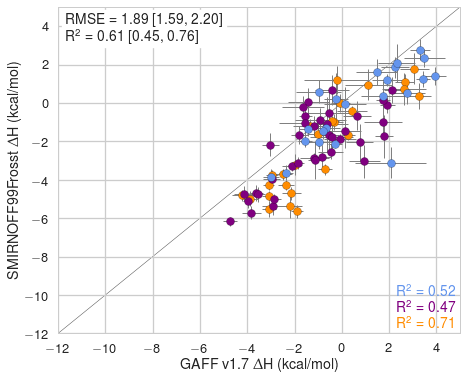

In [76]:
# SMIRNOFF99Frosst vs. GAFF v1.7

df = smirnoff.merge(bgbg_tip3p, on=["System", "Type"], suffixes=("_smirnoff",
                                                                "_bgbg_tip3p"))
assert(len(df) == 86)

artist = scatter(df, 
        x="total_bgbg_tip3p",
        y="total_smirnoff",
        xerr="total_sem_bgbg_tip3p",
        yerr="total_sem_smirnoff",
        xlabel=r"GAFF v1.7 $\Delta$H (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$H (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-GAFF-v1.7-dH.pdf")

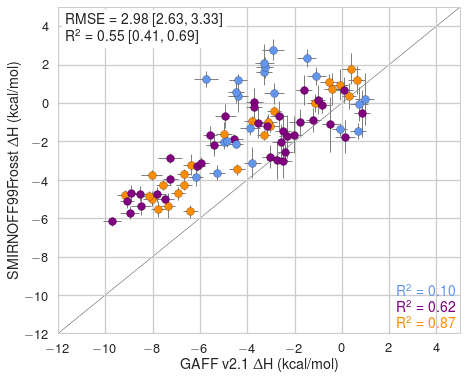

In [77]:
# SMIRNOFF99Frosst vs. GAFF v2.1

df = smirnoff.merge(bg2bg2_tip3p, on=["System", "Type"], suffixes=("_smirnoff",
                                                                "_bg2bg2_tip3p"))
assert(len(df) == 86)

scatter(df, 
        x="total_bg2bg2_tip3p",
        y="total_smirnoff",
        xerr="total_sem_bg2bg2_tip3p",
        yerr="total_sem_smirnoff",
        xlabel=r"GAFF v2.1 $\Delta$H (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$H (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-GAFF-v2.1-dH.pdf")

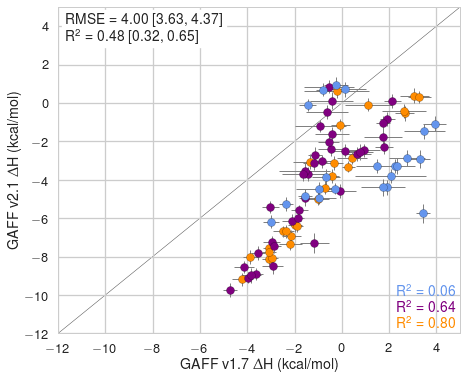

In [78]:
# GAFF v1.7 vs. GAFF v2.1

df = bgbg_tip3p.merge(bg2bg2_tip3p, on=["System", "Type"], suffixes=("_bgbg_tip3p",
                                                                "_bg2bg2_tip3p"))
assert(len(df) == 86)

scatter(df, 
        x="total_bgbg_tip3p",
        y="total_bg2bg2_tip3p",
        xerr="total_sem_bgbg_tip3p",
        yerr="total_sem_bg2bg2_tip3p",
        xlabel=r"GAFF v1.7 $\Delta$H (kcal/mol)",
        ylabel=r"GAFF v2.1 $\Delta$H (kcal/mol)",
        colors=colors,
        name="GAFF-v2.1-vs-GAFF-v1.7-dH.pdf")

In [65]:
def combine_data(df):

    combined = pd.DataFrame()
    df["Short"] = [i[0:-2] for i in df["System"].values]

    for hg in df["Short"].unique():
        tmp = df[df["Short"] == hg]
        for _, row in tmp.iterrows():
            for p in row["System"].split("-")[2]:
                primary_fe = row["total"]
                primary_sem = row["total_sem"]
            else:
                secondary_fe = row["total"]
                secondary_sem = row["total_sem"]
        results = thermodynamic_bootstrap(
            primary_fe, primary_sem, secondary_fe, secondary_sem
        )

        print(f"{hg} P: {primary_fe:+0.4f} ± {primary_sem:+0.2f} S: {secondary_fe:+0.2f} ± {secondary_sem:+0.2f} → Boot: {results['mean']:+0.2f} ± {results['sem']:+0.2f}")
        combined = combined.append(
            {
                "System": hg,
                "Delta H": results["mean"],
                "SEM": results["sem"],
                "Type": guest_types[hg],
            },
            ignore_index=True,
        )
    return combined


In [66]:
smirnoff_combined = combine_data(smirnoff)

a-bam P: -1.1863 ± +0.35 S: -1.19 ± +0.35 → Boot: -1.65 ± +0.25
a-but P: -0.6723 ± +0.64 S: -0.67 ± +0.64 → Boot: -1.24 ± +0.48
a-cbu P: -2.0544 ± +0.32 S: -2.05 ± +0.32 → Boot: -2.52 ± +0.24
a-chp P: -3.6233 ± +0.39 S: -3.62 ± +0.39 → Boot: -4.09 ± +0.29
a-cpe P: -1.9547 ± +0.31 S: -1.95 ± +0.31 → Boot: -2.40 ± +0.23
a-coc P: -3.8713 ± +0.46 S: -3.87 ± +0.46 → Boot: -4.36 ± +0.34
a-hep P: -4.7217 ± +0.40 S: -4.72 ± +0.40 → Boot: -5.19 ± +0.29
a-ham P: -3.7096 ± +0.29 S: -3.71 ± +0.29 → Boot: -4.15 ± +0.21
a-hp6 P: -4.7466 ± +0.39 S: -4.75 ± +0.39 → Boot: -5.22 ± +0.28
a-hex P: -3.9825 ± +0.28 S: -3.98 ± +0.28 → Boot: -4.42 ± +0.21
a-hx2 P: -3.2917 ± +0.24 S: -3.29 ± +0.24 → Boot: -3.73 ± +0.18
a-hpa P: -4.2650 ± +0.25 S: -4.26 ± +0.25 → Boot: -4.71 ± +0.17
a-mba P: -0.9913 ± +0.42 S: -0.99 ± +0.42 → Boot: -1.46 ± +0.31
a-hx3 P: -3.1135 ± +0.31 S: -3.11 ± +0.31 → Boot: -3.56 ± +0.22
a-mhp P: -4.8676 ± +0.26 S: -4.87 ± +0.26 → Boot: -5.31 ± +0.19
a-mha P: -3.2155 ± +0.55 S: -3.22 ± +0.5

In [67]:
bgbg_combined = combine_data(bgbg_tip3p)

a-bam P: -1.3464 ± +0.72 S: -1.35 ± +0.72 → Boot: -1.92 ± +0.56
a-but P: -1.5387 ± +0.29 S: -1.54 ± +0.29 → Boot: -1.99 ± +0.20
a-cbu P: -0.9794 ± +0.73 S: -0.98 ± +0.73 → Boot: -1.53 ± +0.58
a-chp P: -2.3679 ± +0.29 S: -2.37 ± +0.29 → Boot: -2.82 ± +0.22
a-cpe P: -1.5488 ± +0.30 S: -1.55 ± +0.30 → Boot: -2.00 ± +0.21
a-coc P: -2.9951 ± +0.32 S: -3.00 ± +0.32 → Boot: -3.44 ± +0.24
a-hep P: -4.1345 ± +0.42 S: -4.13 ± +0.42 → Boot: -4.61 ± +0.31
a-ham P: -2.5099 ± +0.40 S: -2.51 ± +0.40 → Boot: -2.99 ± +0.29
a-hp6 P: -3.5358 ± +0.30 S: -3.54 ± +0.30 → Boot: -3.98 ± +0.22
a-hex P: -2.9739 ± +0.35 S: -2.97 ± +0.35 → Boot: -3.44 ± +0.26
a-hx2 P: -2.1290 ± +0.41 S: -2.13 ± +0.41 → Boot: -2.63 ± +0.31
a-hpa P: -3.0882 ± +0.23 S: -3.09 ± +0.23 → Boot: -3.53 ± +0.17
a-mba P: -0.3498 ± +0.40 S: -0.35 ± +0.40 → Boot: -0.85 ± +0.31
a-hx3 P: -1.8584 ± +0.24 S: -1.86 ± +0.24 → Boot: -2.29 ± +0.18
a-mhp P: -3.0958 ± +0.27 S: -3.10 ± +0.27 → Boot: -3.53 ± +0.19
a-mha P: -1.9740 ± +0.31 S: -1.97 ± +0.3

In [68]:
bg2bg2_combined = combine_data(bg2bg2_tip3p)

a-bam P: -3.0518 ± +0.39 S: -3.05 ± +0.39 → Boot: -3.53 ± +0.28
a-but P: -4.9314 ± +0.44 S: -4.93 ± +0.44 → Boot: -5.42 ± +0.34
a-cbu P: -4.9746 ± +0.31 S: -4.97 ± +0.31 → Boot: -5.41 ± +0.22
a-chp P: -5.2691 ± +0.35 S: -5.27 ± +0.35 → Boot: -5.73 ± +0.25
a-cpe P: -4.8592 ± +0.29 S: -4.86 ± +0.29 → Boot: -5.29 ± +0.22
a-coc P: -6.1791 ± +0.32 S: -6.18 ± +0.32 → Boot: -6.64 ± +0.23
a-hep P: -8.5469 ± +0.31 S: -8.55 ± +0.31 → Boot: -8.99 ± +0.22
a-ham P: -6.6948 ± +0.30 S: -6.69 ± +0.30 → Boot: -7.13 ± +0.22
a-hp6 P: -7.8294 ± +0.37 S: -7.83 ± +0.37 → Boot: -8.30 ± +0.28
a-hex P: -7.2521 ± +0.33 S: -7.25 ± +0.33 → Boot: -7.70 ± +0.25
a-hx2 P: -6.1275 ± +0.33 S: -6.13 ± +0.33 → Boot: -6.58 ± +0.24
a-hpa P: -7.5627 ± +0.32 S: -7.56 ± +0.32 → Boot: -8.02 ± +0.23
a-mba P: -3.1186 ± +0.36 S: -3.12 ± +0.36 → Boot: -3.59 ± +0.26
a-hx3 P: -5.9775 ± +0.34 S: -5.98 ± +0.34 → Boot: -6.42 ± +0.25
a-mhp P: -8.1384 ± +0.32 S: -8.14 ± +0.32 → Boot: -8.60 ± +0.23
a-mha P: -6.3702 ± +0.37 S: -6.37 ± +0.3

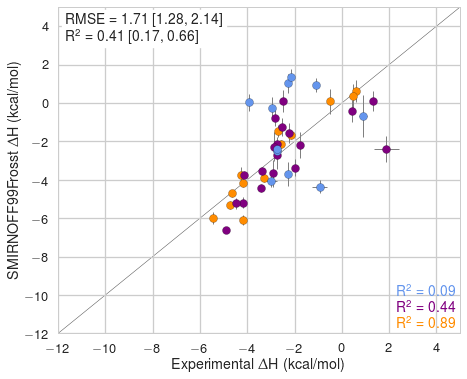

In [79]:
# SMIRNOFF99Frosst vs. Experiment

df = smirnoff_combined.merge(experimental, on=["System"], suffixes=("_smirnoff",
                                                                "_experiment"))
assert(len(df) == 43)

scatter(df, 
        x="Delta H_experiment",
        y="Delta H_smirnoff",
        xerr="SEM_experiment",
        yerr="SEM_smirnoff",
        xlabel=r"Experimental $\Delta$H (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$H (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-Experiment-dH.pdf")

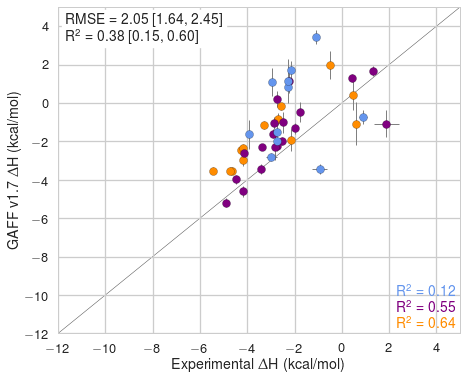

In [80]:
# GAFF v1.7 vs. Experiment

df = bgbg_combined.merge(experimental, on=["System"], suffixes=("_bgbg",
                                                                "_experiment"))
assert(len(df) == 43)

scatter(df, 
        x="Delta H_experiment",
        y="Delta H_bgbg",
        xerr="SEM_experiment",
        yerr="SEM_bgbg",
        xlabel=r"Experimental $\Delta$H (kcal/mol)",
        ylabel=r"GAFF v1.7 $\Delta$H (kcal/mol)",
        colors=colors,
        name="GAFF-v1.7-vs-Experiment-dH.pdf")

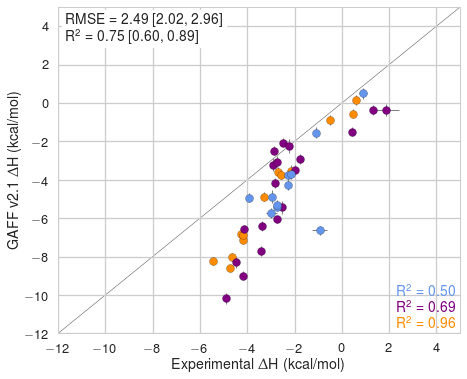

In [81]:
# GAFF v2.1 vs. Experiment

df = bg2bg2_combined.merge(experimental, on=["System"], suffixes=("_bg2bg2",
                                                                "_experiment"))
assert(len(df) == 43)

scatter(df, 
        x="Delta H_experiment",
        y="Delta H_bg2bg2",
        xerr="SEM_experiment",
        yerr="SEM_bg2bg2",
        xlabel=r"Experimental $\Delta$H (kcal/mol)",
        ylabel=r"GAFF v2.1 $\Delta$H (kcal/mol)",
        colors=colors,
        name="GAFF-v2.1-vs-Experiment-dH.pdf")

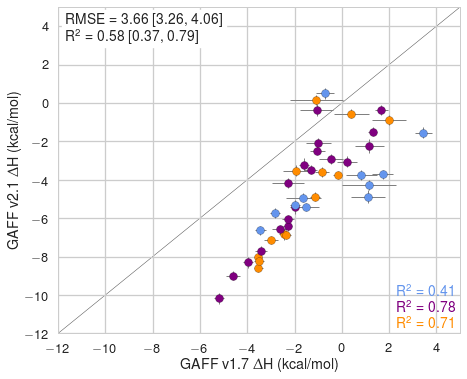

In [82]:
# GAFF v1.7 vs. GAFF v2.1

df = bg2bg2_combined.merge(bgbg_combined, on=["System", "Type"], suffixes=("_bg2bg2",
                                                                "_bgbg"))
assert(len(df) == 43)

scatter(df, 
        x="Delta H_bgbg",
        y="Delta H_bg2bg2",
        xerr="SEM_bgbg",
        yerr="SEM_bg2bg2",
        xlabel=r"GAFF v1.7 $\Delta$H (kcal/mol)",
        ylabel=r"GAFF v2.1 $\Delta$H (kcal/mol)",
        colors=colors,
        name="GAFF-v2.1-vs-GAFF-v1.7-combined-dH.pdf")

In [431]:
df[abs(df["Delta G_bg2bg2"] - df["Delta G_bgbg"]) < 0.05]

,Delta G_bg2bg2,SEM_bg2bg2,System,Type,Delta G_bgbg,SEM_bgbg
22,-1.476478,0.175679,b-ben,aliphatic_carboxylates,-1.492898,0.250359
